In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Mengubah parameter default matplotlib
Parameter default matplotlib dapat diubah dengan rcParams sebagai berikut


In [ ]:
from matplotlib import rcParams

rcParams['figure.figsize'] = 12, 4
rcParams['lines.linewidth'] = 3
rcParams['xtick.labelsize'] = 'x-large'
rcParams['ytick.labelsize'] = 'x-large'

## Load dataset

Untuk hands-on kita akan melihat dataset sintetik prediksi kebotakan. Agar running time-nya tidak terlalu lama, kali ini kita ambil sampel 1000 baris data saja.

In [ ]:
# change file path if necessary
df = pd.read_csv('/content/drive/MyDrive/Rakamin/ML preparation II/botak.csv').sample(1000, random_state=42)

## Descriptive Statistics
### Memeriksa kolom-kolom dan nilai hilang dengan `df.info()`

Hal pertama yang biasanya dilakukan dalam EDA adalah mengecek tipe data setiap kolom dan jumlah nilai yang hilang. Hal ini bisa kita lakukan dengan menggunakan `df.info()`.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1142 to 7212
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   umur           1000 non-null   float64
 1   jenis_kelamin  1000 non-null   object 
 2   pekerjaan      986 non-null    object 
 3   provinsi       1000 non-null   object 
 4   gaji           1000 non-null   float64
 5   is_menikah     1000 non-null   int64  
 6   is_keturunan   997 non-null    float64
 7   berat          1000 non-null   float64
 8   tinggi         1000 non-null   float64
 9   sampo          1000 non-null   object 
 10  is_merokok     1000 non-null   int64  
 11  pendidikan     1000 non-null   object 
 12  botak_prob     1000 non-null   float64
dtypes: float64(6), int64(2), object(5)
memory usage: 109.4+ KB


Kita dapat melihat bahwa:
* Dataframe memiliki total 1000 baris dan 13 kolom
* Dataframe masih memiliki *null* values di kolom `pekerjaan`
* Target klasifikasi sepertinya adalah kolom `botak_prob` dengan tipe data `float64`
* Berarti sisanya adalah *feature*

Dari informasi di atas, kita bisa pisahkan kolom kategorical dan numerical sebagai berikut:

In [ ]:
cats = ['jenis_kelamin', 'pekerjaan', 'sampo', 'pendidikan', 'provinsi']
nums = ['umur', 'gaji', 'is_menikah', 'is_keturunan', 'berat', 'tinggi', 'is_merokok', 'botak_prob']

Tentu saja menyimpan nama kolom berdasarkan tipe *numeric* dan *categorical* seperti di atas tidak wajib, tapi ini lumayan akan memudahkan beberapa proses ke depannya.

### Sampling untuk memahami data dengan `df.sample()`

Setelah mengetahui kolom apa saja yang ada di dalam dataset, kita lakukan sampling untuk memastikan apakah isi kolomnya sesuai ekspektasi. Biasakan lakukan ini beberapa kali karena seringkali apabila ada keanehan tidak akan keluar pada sampling pertama.

Sampling dapat dilakukan dengan menggunakan `df.sample()`

In [ ]:
df.sample(10)

,umur,jenis_kelamin,pekerjaan,provinsi,gaji,is_menikah,is_keturunan,berat,tinggi,sampo,is_merokok,pendidikan,botak_prob
3966,26.0,Laki-laki,Pegawai swasta,Mataram,1.241781e+07,0,0.0,61.482611,156.242512,Moonsilk,0,S1,0.265293
1729,23.0,Laki-laki,PNS,Ambon,9.310764e+06,0,1.0,49.139686,157.650059,Deadbuoy,0,SMA,0.633245
1894,42.0,Perempuan,NaN,Denpasar,1.029432e+07,0,0.0,50.530599,155.090471,Shoulder & Head,0,S1,0.152196
509,42.0,Laki-laki,PNS,Palu,1.665598e+07,0,0.0,61.936910,155.729082,Merpati,0,S1,0.562444
4638,45.0,Laki-laki,Pegawai swasta,Palembang,1.811831e+07,0,0.0,77.794177,169.425952,Moonsilk,1,S1,0.397045
3662,20.0,Perempuan,Pegawai swasta,Sofifi,1.309418e+07,0,0.0,79.975900,164.576882,Merpati,1,S1,0.240579
2515,22.0,Laki-laki,PNS,Tanjungselor,8.272619e+06,0,0.0,43.572481,151.913601,Moonsilk,0,SMA,0.350886
4168,25.0,Laki-laki,Pegawai swasta,Jakarta,3.705080e+06,0,0.0,47.456032,147.487180,Shoulder & Head,0,SMA,0.187921
435,46.0,Perempuan,Pegawai swasta,Semarang,1.133097e+07,0,0.0,54.427109,155.560728,Merpati,0,SMP,0.286574
4490,44.0,Perempuan,Pegawai swasta,Jakarta,6.622666e+06,0,1.0,47.935235,156.517659,Shoulder & Head,0,S3,0.581813


Beberapa pengamatan:
* Target kita, `botak_prob` benar bertipe float dengan *range* 0-1, dimana 1 melambangkan kemungkinan 100%

### Statistical summary dengan `df.describe()`
Selanjutnya kita munculkan ringkasan statistik dataframe, baik untuk numerical dan categorical. Hal ini dilakukan untuk mengecek secara singkat akan keberadaan outlier dan karakteristik distribusi untuk `feature` numeric.

In [ ]:
df[nums].describe()

,umur,gaji,is_menikah,is_keturunan,berat,tinggi,is_merokok,botak_prob
count,1000.000000,1.000000e+03,1000.000000,997.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,39.517000,9.338530e+06,0.035000,0.179539,55.960354,157.308522,0.485000,0.384868
std,10.031667,4.816192e+06,0.183872,0.383995,9.441493,6.550181,0.500025,0.193882
min,4.000000,1.990399e+06,0.000000,0.000000,41.754150,138.487317,0.000000,-0.115700
25%,33.000000,5.985189e+06,0.000000,0.000000,49.723461,152.782408,0.000000,0.241132
50%,39.000000,8.082501e+06,0.000000,0.000000,53.780701,156.979853,0.000000,0.365464
75%,46.000000,1.162239e+07,0.000000,0.000000,59.645683,161.242447,1.000000,0.508360
max,72.000000,3.713150e+07,1.000000,1.000000,128.643924,193.484937,1.000000,1.000000


Beberapa pengamatan dari *statistical summary* kolom numerik di atas:
* Distribusi nilai di kolom `umur` dan `gaji` terlihat normal (*mean* dan *median* cukup dekat, dan nilai Q2 kira2 tepat di tengah2 Q1 - Q3)
* Ada baris yang memiliki probability `botak_prob` minus. Baris ini harus dihilangkan di tahap pre-processing nanti

In [ ]:
df[df['botak_prob']<0].shape

(7, 13)

In [ ]:
df[cats].describe()

,jenis_kelamin,pekerjaan,sampo,pendidikan,provinsi
count,1000,986,1000,1000,1000
unique,2,4,5,6,34
top,Laki-laki,Pegawai swasta,Merpati,S1,Mataram
freq,654,403,225,565,44


Beberapa pengamatan dari *statistical summary* kolom kategorikal di atas:
* Mayoritas data adalah Laki-laki (Top kolom `jenis_kelamin` adalah `Laki-laki` dengan frekuensi 655)
* Kolom `provinsi` memiliki jumlah nilai unik yang banyak;ada kemungkinan tidak terlalu berguna untuk klasifikasi
* Sebaran nilai di kolom `jenis_kelamin`, `provinsi` dan `sampo` terlihat merata, sedangkan `pekerjaan` dan `pendidikan` terlihat didominasi nilai tertentu

### Value Counting
Kita dapat memastikan pengamatan mengenai kolom-kolom *categorical* di atas dengan value counting

In [ ]:
for col in cats:
    print(f'''Value count kolom {col}:''')
    print(df[col].value_counts())
    print()

Value count kolom jenis_kelamin:
Laki-laki    654
Perempuan    346
Name: jenis_kelamin, dtype: int64

Value count kolom pekerjaan:
Pegawai swasta    403
PNS               389
Freelance         159
Pengangguran       35
Name: pekerjaan, dtype: int64

Value count kolom sampo:
Merpati            225
Pantone            210
Moonsilk           198
Deadbuoy           189
Shoulder & Head    178
Name: sampo, dtype: int64

Value count kolom pendidikan:
S1     565
SMA    248
S2      76
SMP     71
SD      24
S3      16
Name: pendidikan, dtype: int64

Value count kolom provinsi:
Mataram           44
Semarang          42
Manokwari         42
Tanjungselor      39
Jambi             36
Pekanbaru         35
Manado            34
Medan             34
Mamuju            32
Ambon             32
Palangkaraya      31
Gorontalo         30
Jakarta           30
Banjarmasin       30
Sofifi            29
Kupang            28
Banda Aceh        28
Serang            28
Padang            28
Banda Lampung     28
Samarin

Seperti yang bisa dilihat, pengamatan kita dari `df.describe()` tadi terbukti benar.

## Univariate Analysis
Setelah melakukan analisis sederhana tentang statistik deskriptif, sekarang kita fokus pada satu-persatu kolom dengan *Univariate Analysis*

### Box plots

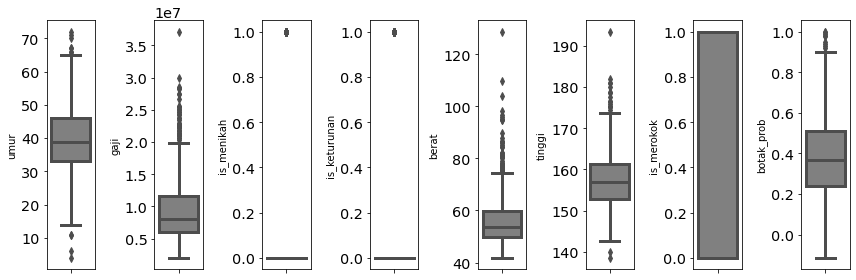

In [ ]:
for i in range(0, len(nums)):
    plt.subplot(1, len(nums), i+1)
    sns.boxplot(y=df[nums[i]], color='gray', orient='v')
    plt.tight_layout()

Untuk boxplot, hal paling penting yang harus kita perhatikan adalah keberadaan outlier.
* Outlier terlihat utamanya pada kolom `gaji` dan `berat`
* Dari boxplotnya terlihat mana distribusi yang terlihat agak *skewed*: `gaji`, `berat`, `tinggi`

### Dist plots

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

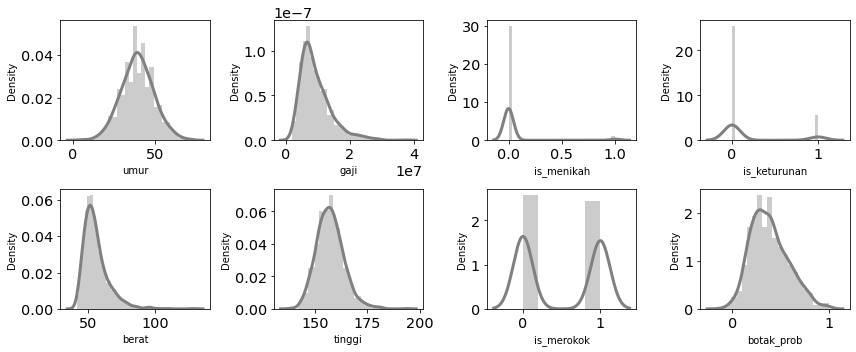

In [ ]:
plt.figure(figsize=(12, 5))
for i in range(0, len(nums)):
    plt.subplot(2, len(nums)/2, i+1)
    sns.distplot(df[nums[i]], color='gray')
    plt.tight_layout()

Untuk distribution plot, hal utama yang perlu diperhatikan adalah bentuk distribusi:
* Seperti dugaan kita ketika melihat boxplot di atas, kolom `gaji`, `berat`, dan `tinggi` sedikit *skewed*
* Berarti ada kemungkinan kita perlu melakukan sesuatu pada kolom2 tersebut nantinya
* Selain kolom2 itu distribusinya terlihat normal-normal saja

### Count plot (categorical)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

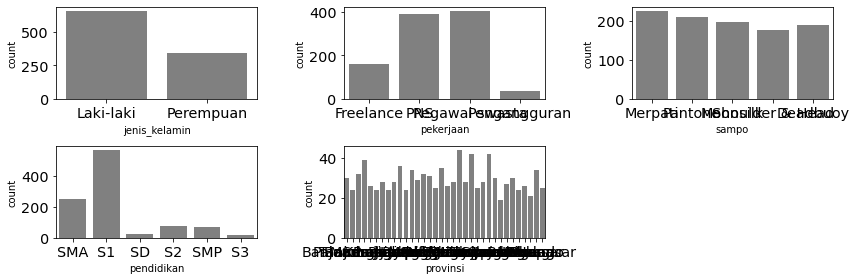

In [ ]:
for i in range(0, len(cats)):
    plt.subplot(2, 3, i+1)
    sns.countplot(df[cats[i]], color='gray', orient='v')
    plt.tight_layout()

Terakhir kita lihat count plot untuk setiap data. Seperti pengamatan kita sebelumnya, distribusi `pendidikan` dan `pekerjaan` didominasi 1-2 value.


## Bivariate Analysis

Setelah menilik setiap kolom secara individual, sekarang kita akan melihat hubungan antar kolom. Mengetahui hubungan antar kolom dapat membantu kita memilih fitur-fitur yang paling penting dan mengesampingkan *feature* yang redundan.

### Correlation heatmap

In [ ]:
df.corr()

,umur,gaji,is_menikah,is_keturunan,berat,tinggi,is_merokok,botak_prob
umur,1.000000,-0.051310,0.436266,0.000896,-0.015623,0.030225,0.024397,0.339214
gaji,-0.051310,1.000000,-0.030682,0.027093,0.002633,-0.002288,0.034678,0.070522
is_menikah,0.436266,-0.030682,1.000000,0.038568,0.039649,0.083794,0.011160,0.239355
is_keturunan,0.000896,0.027093,0.038568,1.000000,0.063689,0.020268,0.025744,0.622825
berat,-0.015623,0.002633,0.039649,0.063689,1.000000,0.640597,0.056122,0.030708
tinggi,0.030225,-0.002288,0.083794,0.020268,0.640597,1.000000,0.006473,0.036609
is_merokok,0.024397,0.034678,0.011160,0.025744,0.056122,0.006473,1.000000,0.306522
botak_prob,0.339214,0.070522,0.239355,0.622825,0.030708,0.036609,0.306522,1.000000


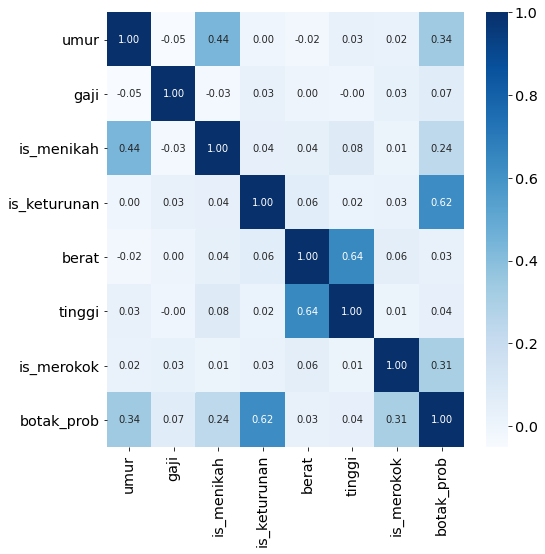

In [ ]:
plt.figure(figsize=(8, 8))
sns.heatmap(df.corr(), cmap='Blues', annot=True, fmt='.2f')

Dari *correlation heatmap* di atas dapat dilihat bahwa:
* Target kita `botak_prob` memiliki korelasi positif lemah dengan `umur`, `is_menikah`, dan `is_merokok`
* Ia juga memiliki korelasi positif kuat dengan `is_keturunan`
* `tinggi` juga memiliki korelasi positif kuat dengan `berat`. Ada kemungkinan kedua *feature* ini redundan
* `is_menikah` memiliki korelasi dengan `umur`, namun korelasi ini lemah

## EDA Conclusion
Beberapa hal yang kita temukan dari EDA dataset ini adalah:
* Data terlihat valid dan tidak ada kecacatan yang major
* Namun masih ada data-data yang kosong/hilang, harus diurus ketika preprocessing
* Ada beberapa distribusi yang sedikit *skewed*, hal ini harus diingat apabila kita ingin melakukan sesuatu atau menggunakan model yang memerlukan asumsi distribusi normal
* Beberapa *feature* memiliki korelasi yang jelas dengan *target*, mereka akan dipakai
* Beberapa *feature* terlihat sama sekali tidak berkorelasi, mereka sebaiknya diabaikan
* Dari Heatmap: ada feature yang korelasinya tinggi satu sama lain (berat/tinggi) mungkin cuma akan dipakai satu